# 8.1.3 TruncatedSVD y Latent Semantic Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pprint import pprint
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

Link: https://youtu.be/sqKxx4zXZNY?si=Hpd3hc2frxtU_UEf

El objeto TruncatedSVD implementa una variación de la descomposición en valores singulares (SVD) que computa únicamente los $k$ valores singulares más grandes.

Cuando esta metodología **TruncatedSVD** es aplicada a la matriz término-documento, es conocida como análisis semantico latente, ya que transforma la matriz a un espacio semántico de baja dimensionalidad.

Esta metodología es muy similar a PCA pero difiere en que la matriz de termino-documento no necesita ser centrada.

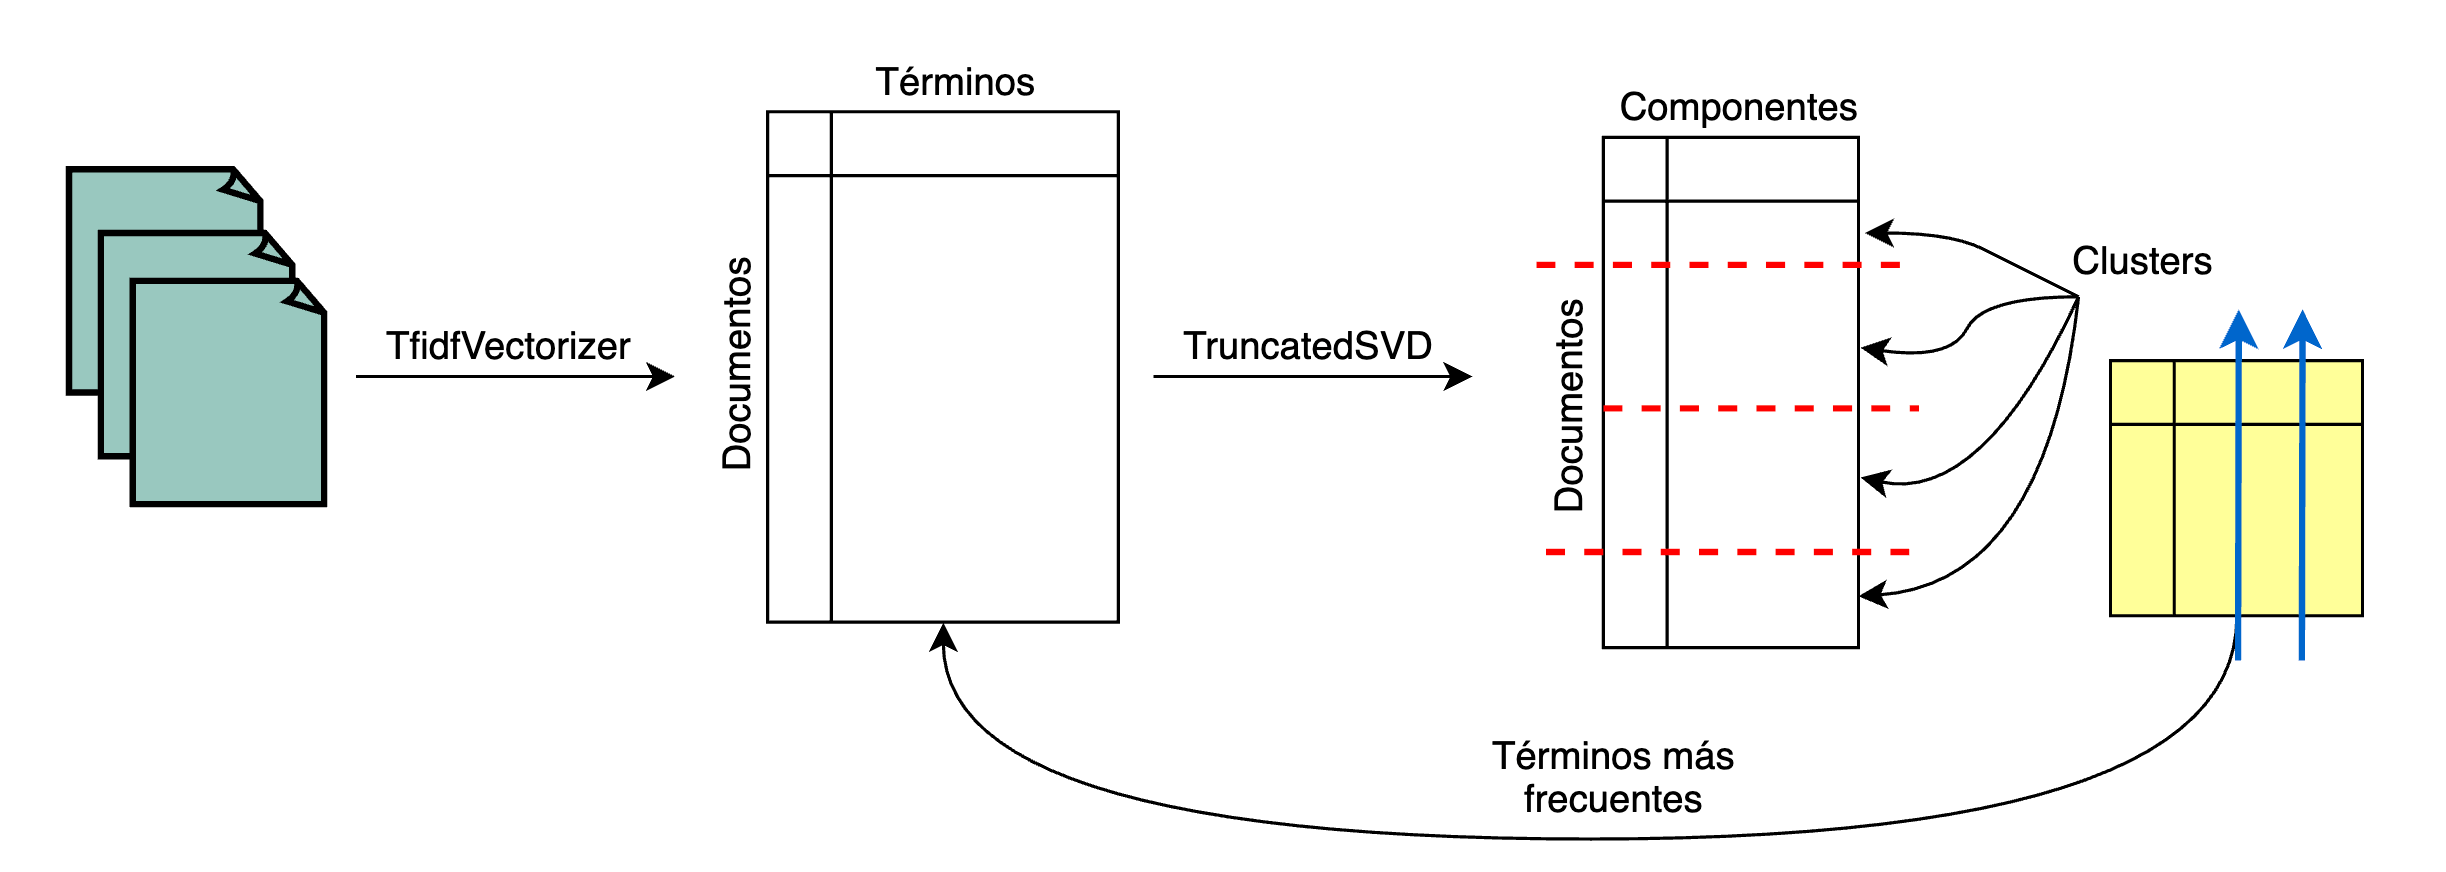

In [3]:
#
# Carga de datos
#
newsgroups = fetch_20newsgroups(
    subset="all", categories=None, shuffle=True, random_state=12345
)

documents = newsgroups.data
target = newsgroups.target
n_groups = np.unique(target).shape[0]

print(" documents: {:d}".format(len(newsgroups.data)))
print("categories: {:d}".format(len(newsgroups.target_names)))
print()
pprint(list(newsgroups.target_names))

 documents: 18846
categories: 20

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [4]:
#
# Ejemplo del primer documento
#
print(documents[0])

From: grady@netcom.com (1016/2EF221)
Subject: Re: freely distributable public key cryptography c++ code:  where?
Organization: capriccioso
X-Newsreader: TIN [version 1.1 PL6]
Lines: 20

Victor Iseli (victori@xetron.com) wrote:
: 
: 
: "Numerical Recipes in C"..Fortran..Pascal  has a nice section on
: encryption and decryption based on the DES algorithm.  There is
: also source code provided (I think some versions of this book are 
: distributed with the source code on disk; the source code can
: also be ordered from the publisher).
: 
: --Victor Iseli
: victori@xetron.com

Yes I benchmarked the DES implementation in the Recipes in C
book.. it is about 1 1/2 orders of magnitude SLOWER than the
Outerbridge/Karn/Gillogly/et al implementation.

It may be instructional, but it isn't very fast.
-- 
grady@netcom.com  2EF221 / 15 E2 AD D3 D1 C6 F3 FC  58 AC F7 3D 4F 01 1E 2F




In [5]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    max_features=1000,
    min_df=2,
    stop_words="english",
    use_idf=False,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
)

dt_matrix = vectorizer.fit_transform(documents)
dt_matrix.shape

(18846, 1000)

In [6]:
truncatedSVD = TruncatedSVD(
    # --------------------------------------------------------------------------
    # Desired dimensionality of output data.
    n_components=600,
    # --------------------------------------------------------------------------
    # SVD solver to use.
    # * 'arpack'
    # * 'randomized'
    algorithm='randomized',
    # --------------------------------------------------------------------------
    # Number of iterations for randomized SVD solver. Not used by ARPACK.
    n_iter=5,
    # --------------------------------------------------------------------------
    # Number of oversamples for randomized SVD solver. Not used by ARPACK.
    n_oversamples=10,
    # --------------------------------------------------------------------------
    # Power iteration normalizer for randomized SVD solver. Not used by ARPACK.
    # * 'auto'
    # * 'QR'
    # * 'LU'
    # * 'none'
    power_iteration_normalizer='auto',
    # --------------------------------------------------------------------------
    # Used during randomized svd. Pass an int for reproducible results across
    # multiple function calls.
    random_state=None,
    # --------------------------------------------------------------------------
    # Tolerance for ARPACK. 0 means machine precision. Ignored by randomized
    # SVD solver.
    tol=0.0,
)


normalizer = Normalizer(copy=False)
pipeline = make_pipeline(truncatedSVD, normalizer)

dt_svd = pipeline.fit_transform(dt_matrix)
dt_svd.shape

(18846, 600)

In [7]:
explained_variance = truncatedSVD.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 87%


In [8]:
kmeans = KMeans(
    n_clusters=n_groups,
    init="k-means++",
    max_iter=100,
    n_init=1,
)

kmeans.fit(dt_svd)

KMeans(max_iter=100, n_clusters=20, n_init=1)

In [9]:
original_space_centroids = truncatedSVD.inverse_transform(kmeans.cluster_centers_)

order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = vectorizer.get_feature_names_out()
for i in range(n_groups):
    print("Cluster %d:" % i, end="")
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind], end="")
    print()

Cluster 0: don like just think know article people com good time
Cluster 1: com article netcom like don just know time people distribution
Cluster 2: university thanks article know state virginia uiuc new like does
Cluster 3: com posting article host nntp reply distribution sun like just
Cluster 4: state ohio acs university article posting nntp host com just
Cluster 5: ca article university posting canada host nntp com bnr like
Cluster 6: god jesus people believe com don does say bible think
Cluster 7: nasa gov space article posting host nntp com center like
Cluster 8: cs article university computer science posting host nntp pitt dept
Cluster 9: people article government com don israel right just said think
Cluster 10: drive scsi hard ide drives disk com controller university problem
Cluster 11: uk ac university article com posting host nntp just know
Cluster 12: posting host nntp university article distribution know like just thanks
Cluster 13: hp com article posting host nntp newsrea

In [10]:
print('ok_')

ok_
